In [ ]:
# %pip install -q numpy pandas scikit-learn tensorflow scipy matplotlib seaborn

import os
import time
import json
import threading
import warnings
from dataclasses import dataclass, asdict
from datetime import datetime
from collections import defaultdict, deque
from typing import Dict, Any, Optional
from sklearn.svm import OneClassSVM

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, mean_absolute_error
)

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, Add, LayerNormalization, GlobalAveragePooling1D, MultiHeadAttention
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

print('✅ Imports loaded')


✅ Imports loaded


In [ ]:
class MessageBroker:
    """MQTT-like broker supporting policy update & feedback topics"""
    def __init__(self):
        self.topics = defaultdict(deque)
        self.subscribers = defaultdict(list)
        self.lock = threading.Lock()
        self.message_history = defaultdict(list)

    def publish(self, topic: str, payload: Dict[str, Any], qos: int = 1):
        with self.lock:
            msg = {
                'timestamp': datetime.now().isoformat(),
                'topic': topic,
                'payload': payload,
                'qos': qos
            }
            self.topics[topic].append(msg)
            self.message_history[topic].append(msg)
            for cb in self.subscribers[topic]:
                try:
                    cb(topic, msg)
                except Exception:
                    pass

    def subscribe(self, topic: str, callback):
        with self.lock:
            self.subscribers[topic].append(callback)

    def get_latest(self, topic: str, default=None):
        with self.lock:
            return self.topics[topic][-1] if self.topics[topic] else default


broker = MessageBroker()

TOPICS = {
    'edge_features': 'edge/features',
    'fog_predictions': 'fog/predictions',
    'fog_reasoning': 'fog/reasoning',
    'actions': 'actions/direct',
    'external_alerts': 'external/alerts',
    'monitoring': 'monitor/logs',
    'policy_update': 'policy/update',           # Cloud → Fog policy
    'feedback_edge': 'feedback/edge'             # Cloud → Edge feedback
}

print('✅ Broker initialized (8 topics)')


✅ Broker initialized (8 topics)


In [ ]:
# CELL 3: POLICY & FEEDBACK STRUCTURES (FIXED for Python 3.12 dataclasses)

from dataclasses import dataclass, asdict, field

@dataclass
class EdgePolicy:
    """Policies for Edge layer (tunable)"""
    window_size: int = 10

@dataclass
class FogPolicy:
    """Policies for Fog layer (tunable)"""
    contamination: float = 0.05
    threshold_quantile: float = 0.75
    use_threshold_calibration: bool = True

@dataclass
class PolicyState:
    """Complete policy state (uses default_factory to avoid mutable defaults)"""
    edge: EdgePolicy = field(default_factory=EdgePolicy)
    fog: FogPolicy = field(default_factory=FogPolicy)

policy_state = PolicyState()

print('✅ PolicyState initialized:', asdict(policy_state))


✅ PolicyState initialized: {'edge': {'window_size': 10}, 'fog': {'contamination': 0.05, 'threshold_quantile': 0.75, 'use_threshold_calibration': True}}


In [ ]:
from google.colab import files
files.upload()


{}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# CELL 4: DATA LOADING (DETAILED - BASELINE1 STYLE)

print("\n📂 Loading Boiler Dataset...")
data_boiler = pd.read_csv('dataset/Boiler_emulator_dataset.csv')
print(f"✅ Boiler loaded: {data_boiler.shape}")

# Process Boiler Dataset
df_boiler_clean = data_boiler.copy()
le_condition = LabelEncoder()
df_boiler_clean['Condition'] = le_condition.fit_transform(df_boiler_clean['Condition'])
le_class = LabelEncoder()
df_boiler_clean['Class'] = le_class.fit_transform(df_boiler_clean['Class'])

numeric_cols = ['Fuel_Mdot', 'Tair', 'Treturn', 'Tsupply', 'Water_Mdot']
for col in numeric_cols:
    df_boiler_clean[col] = pd.to_numeric(df_boiler_clean[col], errors='coerce')
df_boiler_clean = df_boiler_clean.dropna()

X_boiler = df_boiler_clean.drop('Class', axis=1)
y_boiler = df_boiler_clean['Class']

X_train_boiler_full, X_test_boiler, y_train_boiler_full, y_test_boiler = train_test_split(
    X_boiler, y_boiler, test_size=0.2, random_state=42, stratify=y_boiler
)

scaler_b = StandardScaler()
X_train_boiler = pd.DataFrame(scaler_b.fit_transform(X_train_boiler_full), columns=X_train_boiler_full.columns)
X_test_boiler = pd.DataFrame(scaler_b.transform(X_test_boiler), columns=X_test_boiler.columns)

y_test_boiler_anomaly = (y_test_boiler == 1).astype(int)
y_test_boiler_rul = pd.Series(
    np.where(y_test_boiler == 1, np.random.randint(5, 30, len(y_test_boiler)), np.random.randint(30, 100, len(y_test_boiler)))
)

print(f"✅ Boiler - Train {X_train_boiler.shape}, Test {X_test_boiler.shape}")

print("\n📂 Loading Wind Turbine Dataset...")
# Load from dataset folder (same location as boiler dataset)
# Download CSV files and place in: dataset/iiot-data-of-wind-turbine/
try:
    scada_df = pd.read_csv('dataset/iiot-data-of-wind-turbine/scada_data.csv')
    scada_df['DateTime'] = pd.to_datetime(scada_df['DateTime'])

    fault_df = pd.read_csv('dataset/iiot-data-of-wind-turbine/fault_data.csv')
    fault_df['DateTime'] = pd.to_datetime(fault_df['DateTime'])

    status_df = pd.read_csv('dataset/iiot-data-of-wind-turbine/status_data.csv')
    status_df['Time'] = pd.to_datetime(status_df['Time'])
    status_df.rename(columns={'Time': 'DateTime'}, inplace=True)

    print("✅ Wind Turbine dataset loaded from dataset/iiot-data-of-wind-turbine/")
    data_source = "Real dataset"

except FileNotFoundError as e:
    print(f"⚠️  Dataset not found: {e}")
    print("📝 To fix this: Download the wind turbine CSV files and place them in:")
    print("   dataset/iiot-data-of-wind-turbine/")
    print("   ├── scada_data.csv")
    print("   ├── fault_data.csv")
    print("   └── status_data.csv")
    print("\n💾 Generating synthetic wind turbine data as fallback...\n")

    # Generate synthetic wind turbine data
    n_samples = 1000
    n_features = 40

    np.random.seed(42)
    scada_data = {'DateTime': pd.date_range('2014-04-01', periods=n_samples, freq='10min')}

    # Add sensor features (temperature, power, position, etc.)
    for i in range(n_features):
        scada_data[f'Sensor_{i}'] = np.random.normal(50, 15, n_samples)

    scada_df = pd.DataFrame(scada_data)
    scada_df['DateTime'] = pd.to_datetime(scada_df['DateTime'])

    # Create fault data
    fault_types = ['gf', 'mf', 'ff', 'af', 'ef']
    fault_data = {
        'DateTime': scada_df['DateTime'].sample(n=200, random_state=42).sort_values().reset_index(drop=True),
        'Fault': np.random.choice(fault_types, size=200)
    }
    fault_df = pd.DataFrame(fault_data)

    # Create status data
    status_df = pd.DataFrame({
        'DateTime': scada_df['DateTime'],
        'Status': np.random.choice(['OK', 'WARNING', 'ERROR'], size=n_samples, p=[0.7, 0.2, 0.1])
    })

    print("✅ Synthetic wind turbine data generated")
    data_source = "Synthetic (fallback)"

# Merge SCADA and Fault data on DateTime
df_turbine = scada_df.merge(fault_df[['DateTime', 'Fault']], on='DateTime', how='left')

# Replace NaN faults with 'NF' (No Fault - normal condition)
df_turbine['Fault'] = df_turbine['Fault'].replace(np.nan, 'NF')

# Sample balanced data
df_nf = df_turbine[df_turbine['Fault']=='NF']
if len(df_nf) > 300:
    df_nf = df_nf.sample(n=300, random_state=42)

df_f = df_turbine[df_turbine['Fault']!='NF']
df_turbine = pd.concat((df_nf, df_f), axis=0).reset_index(drop=True)

# Drop irrelevant features
irrelevant_cols = ['DateTime', 'WEC: ava. windspeed',
                   'WEC: ava. available P from wind',
                   'WEC: ava. available P technical reasons',
                   'WEC: ava. Available P force majeure reasons',
                   'WEC: ava. Available P force external reasons',
                   'WEC: max. windspeed', 'WEC: min. windspeed',
                   'WEC: Operating Hours', 'WEC: Production kWh',
                   'WEC: Production minutes']
irrelevant_cols = [col for col in irrelevant_cols if col in df_turbine.columns]
df_turbine_clean = df_turbine.drop(columns=irrelevant_cols, errors='ignore')

# Extract features and target
X_turbine_full = df_turbine_clean.drop('Fault', axis=1)
y_turbine_full = df_turbine_clean['Fault']

# Encode fault labels
le_turbine = LabelEncoder()
y_turbine_encoded = le_turbine.fit_transform(y_turbine_full)

# Train-test split
X_train_turbine, X_test_turbine, y_train_turbine, y_test_turbine = train_test_split(
    X_turbine_full, y_turbine_encoded, test_size=0.2, random_state=42
)

# Scale features
scaler_t = StandardScaler()
X_train_turbine_scaled = pd.DataFrame(scaler_t.fit_transform(X_train_turbine), columns=X_train_turbine.columns)
X_test_turbine_scaled = pd.DataFrame(scaler_t.transform(X_test_turbine), columns=X_test_turbine.columns)

print(f"✅ Wind Turbine - Train {X_train_turbine_scaled.shape}, Test {X_test_turbine_scaled.shape}")

# Create anomaly labels
y_test_turbine_anomaly = (y_test_turbine > 0).astype(int)

# Create synthetic RUL
y_test_turbine_rul = pd.Series(
    np.where(y_test_turbine_anomaly == 1, np.random.randint(5, 25, len(y_test_turbine)), np.random.randint(25, 100, len(y_test_turbine)))
)

print(f"\n✅ Data loading complete")

# Print Boiler distribution
boiler_dist = pd.Series(y_test_boiler_anomaly).value_counts().to_dict()
print(f"   Boiler anomaly class distribution: {boiler_dist}")

# Print Wind Turbine distribution (convert numpy array to Series first)
turbine_dist = pd.Series(y_test_turbine_anomaly).value_counts().to_dict()
print(f"   Wind Turbine anomaly class distribution: {turbine_dist}")

# Print fault modes
fault_mode_mapping = dict(zip(le_turbine.classes_, le_turbine.transform(le_turbine.classes_)))
print(f"   Wind Turbine fault modes: {fault_mode_mapping}")
print(f"   Wind Turbine RUL threshold: 25 hours (RUL <= 25 = anomaly)")
print(f"   Data source: {data_source}")

# Alias for Baseline2 compatibility
Xtr_boiler, Xte_boiler = X_train_boiler, X_test_boiler
yte_boiler_anom, yte_boiler_rul = y_test_boiler_anomaly.values, y_test_boiler_rul.values
Xtr_turbine, Xte_turbine = X_train_turbine_scaled, X_test_turbine_scaled
yte_turbine_anom, yte_turbine_rul = y_test_turbine_anomaly, y_test_turbine_rul.values


📂 Loading Boiler Dataset...
✅ Boiler loaded: (27280, 7)
✅ Boiler - Train (21824, 6), Test (5456, 6)

📂 Loading Wind Turbine Dataset...
✅ Wind Turbine dataset loaded from dataset/iiot-data-of-wind-turbine/
✅ Wind Turbine - Train (263, 55), Test (66, 55)

✅ Data loading complete
   Boiler anomaly class distribution: {0: 3696, 1: 1760}
   Wind Turbine anomaly class distribution: {1: 61, 0: 5}
   Wind Turbine fault modes: {'EF': np.int64(0), 'FF': np.int64(1), 'GF': np.int64(2), 'MF': np.int64(3), 'NF': np.int64(4)}
   Wind Turbine RUL threshold: 25 hours (RUL <= 25 = anomaly)
   Data source: Real dataset


In [ ]:
class BaseAgent:
    def __init__(self, name: str, broker: MessageBroker):
        self.name = name
        self.broker = broker

    def publish(self, topic: str, payload: Dict[str, Any]):
        self.broker.publish(topic, payload)


In [ ]:
# CELL 6: EDGE AGENT (with policy update capability) — MODIFIED/FIXED

class EdgeAgent(BaseAgent):
    """Edge Layer: Processing with policy updates"""

    def __init__(self, broker: MessageBroker, policy: EdgePolicy):
        super().__init__('EdgeAgent', broker)
        self.policy = policy

    def update_policy(self, policy: EdgePolicy):
        """Receive policy update from Cloud"""
        self.policy = policy

    def extract_features(self, data: np.ndarray) -> Dict[str, np.ndarray]:
        """Extract statistical and spectral features from a chunk.

        FIX:
        - n_features must be data.shape[1] (columns), not data.shape (tuple).
        """
        data = np.asarray(data)

        rms = np.sqrt(np.mean(data**2, axis=0))
        mean_val = np.mean(data, axis=0)
        std_val = np.std(data, axis=0)

        centered = data - mean_val
        kurtosis = np.mean(centered**4, axis=0) / (std_val**4 + 1e-8)
        skewness = np.mean(centered**3, axis=0) / (std_val**3 + 1e-8)

        # ✅ FIX HERE
        n_features = int(data.shape[1])
        x = np.arange(len(data))
        trend = []
        for i in range(n_features):
            try:
                trend.append(np.polyfit(x, data[:, i], 1)[0])
            except np.linalg.LinAlgError:
                # SVD convergence failure - use slope of 0 as fallback
                trend.append(0.0)
        trend = np.array(trend)

        fft_vals = np.fft.fft(data, axis=0)
        spectral_energy = np.abs(fft_vals).mean(axis=0)

        return {
            'rms': rms,
            'kurtosis': kurtosis,
            'skewness': skewness,
            'mean': mean_val,
            'std': std_val,
            'trend': trend,
            'spectral_energy': spectral_energy
        }

    def process_stream(self, X: np.ndarray) -> Dict[str, Any]:
        """Create chunks based on current window_size policy and publish features per chunk."""
        X = np.asarray(X)

        w = int(self.policy.window_size)
        w = max(5, w)
        w = min(w, len(X))

        features_list = []
        for start in range(0, len(X), w):
            chunk = X[start:start + w]
            feats = self.extract_features(chunk)
            features_list.append({k: v.tolist() for k, v in feats.items()})

        payload = {
            'agent': self.name,
            'timestamp': datetime.now().isoformat(),
            'window_size': w,
            'num_chunks': len(features_list),
            'features_per_chunk': features_list
        }

        self.publish(TOPICS['edge_features'], payload)
        return payload

print('✅ Edge Agent defined (modified/fixed)')


✅ Edge Agent defined (modified/fixed)


In [ ]:
# CELL 7: FOG AGENT (Ensemble-based anomaly detection + threshold calibration + policy-driven threshold)

class FogAgent(BaseAgent):
    """Fog Layer: Ensemble anomaly detection with threshold calibration"""

    def __init__(self, broker: MessageBroker, policy: FogPolicy):
        super().__init__('FogAgent', broker)
        self.policy = policy
        self.models = {}
        self.scaler = StandardScaler()
        self.is_first_episode = True
        self.training_data = None
        self.calibrated_threshold = None
        self.policy_quantile_at_calibration = 0.75

    def update_policy(self, policy: FogPolicy):
        """Receive policy updates from Cloud"""
        self.policy = policy

    def train(self, X_train: pd.DataFrame):
        """Train ensemble models"""
        X_train = np.asarray(X_train)

        # Scaler
        self.scaler.fit(X_train)
        X_scaled = self.scaler.transform(X_train)

        # OneClassSVM (40%)
        self.models['ocsvm'] = OneClassSVM(kernel='sigmoid', gamma='auto', nu=self.policy.contamination)
        self.models['ocsvm'].fit(X_scaled)

        # IsolationForest (40%)
        self.models['if'] = IsolationForest(contamination=self.policy.contamination, n_estimators=250, random_state=42)
        self.models['if'].fit(X_scaled)

        # Transformer CNN (20%)
        self.models['transformer'] = self._build_transformer_cnn(X_scaled.shape[1])
        self.models['transformer'].fit(X_scaled, X_scaled, epochs=10, batch_size=32, verbose=0)

        self.training_data = X_train
        print(f'✅ Fog Agent trained on {X_train.shape[0]} samples (3-model ensemble)')

    def _build_transformer_cnn(self, input_dim: int):
        """Build transformer-CNN for anomaly detection"""
        from tensorflow.keras.layers import Lambda, Reshape

        inp = Input(shape=(input_dim,))

        # Reshape input for CNN
        x = Reshape((input_dim, 1))(inp)

        # CNN blocks
        x = Conv1D(32, 3, padding='same', activation='relu')(x)
        x = Conv1D(16, 3, padding='same', activation='relu')(x)

        # Multi-head attention (use Lambda to wrap TF operations)
        x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
        attn = MultiHeadAttention(num_heads=4, key_dim=8)(x, x)
        x = Lambda(lambda t: tf.squeeze(t, axis=1))(attn)

        # Final layers
        x = LayerNormalization()(x)
        x = GlobalAveragePooling1D()(x)
        x = Dense(64, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        out = Dense(input_dim, activation='linear')(x)

        model = Model(inp, out)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return model

    def _calibrate_threshold(self, scores: np.ndarray, y_true: np.ndarray) -> float:
        """Calibrate decision threshold to maximize F1 on labeled data"""
        thresholds = np.percentile(scores, np.arange(10, 91, 5))
        best_f1 = 0
        best_thr = np.median(scores)

        for thr in thresholds:
            pred = (scores > thr).astype(int)
            f1 = f1_score(y_true, pred, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thr = thr

        return best_thr

    def detect_and_reason(self, X_test: np.ndarray, y_test_true: Optional[np.ndarray] = None, episode: int = 1) -> Dict[str, Any]:
        """Ensemble anomaly detection with adaptive threshold + reasoning"""
        X_test = np.asarray(X_test)
        X_scaled = self.scaler.transform(X_test)

        # **Model 1: OneClassSVM (40%)**
        ocsvm_scores = -self.models['ocsvm'].decision_function(X_scaled)
        ocsvm_scores = (ocsvm_scores - ocsvm_scores.min()) / (ocsvm_scores.max() - ocsvm_scores.min() + 1e-8)

        # **Model 2: IsolationForest (40%)**
        if_scores = self.models['if'].score_samples(X_scaled)
        if_scores = -if_scores  # Higher = more anomalous
        if_scores = (if_scores - if_scores.min()) / (if_scores.max() - if_scores.min() + 1e-8)

        # **Model 3: Transformer CNN (20%)**
        recon = self.models['transformer'].predict(X_scaled, verbose=0)
        transformer_scores = np.mean(np.abs(X_scaled - recon), axis=1)
        transformer_scores = (transformer_scores - transformer_scores.min()) / (transformer_scores.max() - transformer_scores.min() + 1e-8)

        # **Ensemble: Weighted average**
        scores = 0.4 * ocsvm_scores + 0.4 * if_scores + 0.2 * transformer_scores

        # **Uncertainty: Standard deviation across models**
        model_scores = np.array([ocsvm_scores, if_scores, transformer_scores])
        uncertainty = np.std(model_scores, axis=0)

        # **Model diversity: Average disagreement**
        model_diversity = np.mean(uncertainty)

        # Apply optimal threshold (calibrate only on first episode, then use policy)
        if self.is_first_episode and y_test_true is not None and self.policy.use_threshold_calibration:
            thr = self._calibrate_threshold(scores, y_test_true)
            self.calibrated_threshold = thr
            self.policy_quantile_at_calibration = self.policy.threshold_quantile  # Remember quantile at calibration
            self.is_first_episode = False  # Only calibrate once
            print(f'  ✅ Threshold calibrated on Episode 1: {thr:.3f} (at quantile {self.policy.threshold_quantile:.2f})')
        elif hasattr(self, 'calibrated_threshold'):
            # After first episode: use policy's threshold_quantile to control the ACTUAL threshold directly
            # DIRECT MAPPING: threshold_quantile IS the decision threshold
            # Lower quantile → Lower threshold → Higher recall
            # Scale the calibrated threshold based on policy change
            scale_factor = self.policy.threshold_quantile / getattr(self, 'policy_quantile_at_calibration', 0.75)
            thr = self.calibrated_threshold * scale_factor
        else:
            q = float(self.policy.threshold_quantile)
            q = min(max(q, 0.5), 0.95)
            thr = float(np.quantile(scores, q))

        pred = (scores > thr).astype(int)

        # Severity score (distance from threshold)
        severity = np.max(scores - thr)

        reasoning = {
            'ocsvm_score': float(np.mean(ocsvm_scores)),
            'if_score': float(np.mean(if_scores)),
            'transformer_score': float(np.mean(transformer_scores)),
            'ensemble_uncertainty': float(np.mean(uncertainty)),
            'model_diversity': float(model_diversity),
            'threshold_value': float(thr),
            'severity': float(severity),
            'episode': episode
        }

        payload = {
            'timestamp': datetime.now().isoformat(),
            'agent': self.name,
            'predictions': pred.tolist(),
            'scores': scores.tolist(),
            'reasoning': reasoning
        }

        self.publish(TOPICS['fog_predictions'], payload)
        self.publish(TOPICS['fog_reasoning'], payload)

        return {
            'pred': pred,
            'scores': scores,
            'uncertainty': uncertainty,
            'reasoning': reasoning
        }

    def update_with_feedback(self, X_feedback: np.ndarray, y_feedback: np.ndarray,
                            uncertainty_scores: Optional[np.ndarray] = None,
                            pred_feedback: Optional[np.ndarray] = None):
        """Online learning: retrain on high-uncertainty or misclassified samples"""
        X_feedback = np.asarray(X_feedback)
        y_feedback = np.asarray(y_feedback)

        if len(X_feedback) == 0:
            return

        X_scaled = self.scaler.transform(X_feedback)

        # Retrain OneClassSVM (incremental-like)
        X_all = np.vstack([self.training_data, X_feedback])
        X_all_scaled = self.scaler.transform(X_all)
        self.models['ocsvm'] = OneClassSVM(kernel='sigmoid', gamma='auto', nu=self.policy.contamination)
        self.models['ocsvm'].fit(X_all_scaled)

        # Retrain IsolationForest
        self.models['if'] = IsolationForest(contamination=self.policy.contamination, n_estimators=250, random_state=42)
        self.models['if'].fit(X_all_scaled)

        # Fine-tune Transformer (few epochs)
        self.models['transformer'].fit(X_scaled, X_scaled, epochs=2, batch_size=16, verbose=0)

        # Update training data
        self.training_data = np.vstack([self.training_data, X_feedback])

        print(f'  📚 Fog Agent updated with {len(X_feedback)} feedback samples')

print('✅ Fog Agent defined (complete with all methods)')


✅ Fog Agent defined (complete with all methods)


In [ ]:
class CloudAgent(BaseAgent):
    """Cloud Layer: Comprehensive metrics, audit, and smart policy evolution"""
    def __init__(self, broker: MessageBroker):
        super().__init__('CloudAgent', broker)
        self.logs = []

    def evaluate(self, y_true: np.ndarray, y_pred: np.ndarray, scores: np.ndarray, y_rul: Optional[np.ndarray]) -> Dict[str, Any]:
        """Evaluate predictions with comprehensive metrics"""
        y_true = np.asarray(y_true).astype(int)
        y_pred = np.asarray(y_pred).astype(int)
        scores = np.asarray(scores)

        # **Standard Anomaly Detection Metrics**
        metrics = {
            'accuracy': float(accuracy_score(y_true, y_pred)),
            'precision': float(precision_score(y_true, y_pred, zero_division=0)),
            'recall': float(recall_score(y_true, y_pred, zero_division=0)),
            'f1': float(f1_score(y_true, y_pred, zero_division=0)),
            'specificity': float(recall_score(y_true, y_pred, pos_label=0, zero_division=0)),  # TNR
            'roc_auc': float(roc_auc_score(y_true, scores) if len(np.unique(y_true)) > 1 else 0.5),
            'mcc': float(matthews_corrcoef(y_true, y_pred)),
        }

        # **Cost-Sensitive Metrics (anomaly detection priorities)**
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tp = np.sum((y_true == 1) & (y_pred == 1))

        # False Positive Rate (cost of false alarms)
        fpr = fp / (fp + tn + 1e-8)
        # False Negative Rate (cost of missed anomalies)
        fnr = fn / (fn + tp + 1e-8)

        # Cost-sensitive F1: penalize false positives and false negatives differently
        # Higher weight on false negatives (missing anomalies is worse)
        cost_weighted_f1 = (1 + 4.0) * (metrics['precision'] * metrics['recall']) / (4.0 * metrics['precision'] + metrics['recall'] + 1e-8)

        metrics.update({
            'false_positive_rate': float(fpr),
            'false_negative_rate': float(fnr),
            'cost_weighted_f1': float(cost_weighted_f1),  # Emphasizes recall
        })

        mae_rul = None
        if y_rul is not None:
            mae_rul = float(mean_absolute_error(np.asarray(y_rul)[:len(y_pred)], y_pred[:len(np.asarray(y_rul))]))

        report = {
            'timestamp': datetime.now().isoformat(),
            'agent': self.name,
            'metrics': metrics,
            'mae_rul': mae_rul,
            'xai_shap_ready': True,
            'status': 'SUCCESS'
        }

        self.logs.append(report)
        self.publish(TOPICS['monitoring'], report)
        return report

    def propose_policy_update(self, report: Dict[str, Any], current: PolicyState) -> PolicyState:
        """Enhanced policy evolution: Smart precision-recall balance"""
        metrics = report['metrics']
        new_state = PolicyState(
            edge=EdgePolicy(window_size=current.edge.window_size),
            fog=FogPolicy(
                contamination=current.fog.contamination,
                threshold_quantile=current.fog.threshold_quantile,
                use_threshold_calibration=current.fog.use_threshold_calibration
            )
        )

        recall = metrics.get('recall', 0)
        fnr = metrics.get('false_negative_rate', 0)
        fpr = metrics.get('false_positive_rate', 0)
        f1 = metrics.get('f1', 0)
        precision = metrics.get('precision', 0)

        # DEBUG: Print metrics to understand what's happening
        print(f'  [Policy] F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, FPR={fpr:.4f}, FNR={fnr:.4f}')
        print(f'  [Policy] Current threshold_quantile={current.fog.threshold_quantile:.3f}', end=' → ')

        # SMART STRATEGY: Balance precision-recall tradeoff
        # If recall is already perfect (>0.95) but F1 is low → problem is PRECISION → RAISE threshold
        # If recall is low (<0.70) and FNR is high → LOWER threshold
        # Otherwise → ADJUST contamination for better balance

        if recall > 0.95 and f1 < 0.65:
            # High recall but low F1 = too many false positives → RAISE threshold
            new_state.fog.threshold_quantile = min(0.85, current.fog.threshold_quantile + 0.10)
            print(f'{new_state.fog.threshold_quantile:.3f} (HIGH RECALL LOW F1: raise +0.10 to fix precision)')
        elif recall > 0.90 and precision < 0.40:
            # Perfect/near-perfect recall but terrible precision → RAISE threshold significantly
            new_state.fog.threshold_quantile = min(0.85, current.fog.threshold_quantile + 0.15)
            print(f'{new_state.fog.threshold_quantile:.3f} (PERFECT RECALL BAD PRECISION: raise +0.15)')
        elif recall < 0.70 and fnr > 0.30:
            # Low recall and many missed anomalies → LOWER threshold
            new_state.fog.threshold_quantile = max(0.30, current.fog.threshold_quantile - 0.15)
            print(f'{new_state.fog.threshold_quantile:.3f} (LOW RECALL HIGH FNR: lower -0.15)')
        elif f1 < 0.50:
            # General poor performance → adjust CONTAMINATION to help model learn better distribution
            # Don't aggressively change threshold if precision/recall balance is very skewed
            new_state.fog.contamination = min(0.15, current.fog.contamination + 0.02)
            print(f'{new_state.fog.threshold_quantile:.3f} (POOR F1: adjust contamination to {new_state.fog.contamination:.3f})')
        elif f1 < 0.70 and fpr < 0.15:
            # Moderate F1 with low false positives → slight threshold reduction is OK
            new_state.fog.threshold_quantile = max(0.40, current.fog.threshold_quantile - 0.08)
            print(f'{new_state.fog.threshold_quantile:.3f} (MODERATE F1 LOW FPR: lower -0.08)')
        elif f1 >= 0.75 and recall > 0.85 and precision > 0.70:
            # Good balance → only tiny adjustments
            new_state.fog.threshold_quantile = min(0.80, current.fog.threshold_quantile + 0.01)
            print(f'{new_state.fog.threshold_quantile:.3f} (GOOD BALANCE: maintain with +0.01)')
        else:
            # No significant change needed
            print(f'{new_state.fog.threshold_quantile:.3f} (maintain)')

        # SAFEGUARD: Adjust contamination if models are too biased
        if precision < 0.35 and recall > 0.90:
            # Model is too aggressive (classifying too much as anomaly) → increase contamination expectation
            new_state.fog.contamination = min(0.20, current.fog.contamination + 0.03)
        elif recall < 0.60 and fpr < 0.10:
            # Model is too conservative → decrease contamination expectation
            new_state.fog.contamination = max(0.02, current.fog.contamination - 0.02)

        # **EDGE POLICY: Adaptive window size based on recall**
        if recall < 0.70:
            new_state.edge.window_size = min(40, current.edge.window_size + 2)
        elif recall > 0.90 and f1 > 0.70:
            new_state.edge.window_size = max(8, current.edge.window_size - 1)

        return new_state

print('✅ CloudAgent defined (complete with all methods)')


✅ CloudAgent defined (complete with all methods)


In [ ]:
class Baseline2System:
    """Complete Baseline2 system with feedback loops"""
    def __init__(self, broker: MessageBroker, policy: PolicyState):
        self.broker = broker
        self.policy = policy
        self.edge = EdgeAgent(broker, policy.edge)
        self.fog = FogAgent(broker, policy.fog)
        self.cloud = CloudAgent(broker)
        self.bench = {'latency_ms': [], 'f1': [], 'mae': []}
        self.policy_history = [asdict(policy)]

    def train(self, X_train: pd.DataFrame):
        self.fog.update_policy(self.policy.fog)
        self.fog.train(X_train)

    def run_episode(self, X_test: pd.DataFrame, y_true: np.ndarray, y_rul: Optional[np.ndarray] = None, episode: int = 1) -> Dict[str, Any]:
        """Single episode with full feedback loop + online learning"""
        start = time.time()

        # Edge processing
        edge_payload = self.edge.process_stream(X_test)

        # Fog detection + reasoning with threshold calibration (only episode 1)
        fog_out = self.fog.detect_and_reason(X_test, y_true if self.fog.policy.use_threshold_calibration else None, episode)

        # Cloud evaluation
        report = self.cloud.evaluate(y_true=y_true, y_pred=fog_out['pred'], scores=fog_out['scores'], y_rul=y_rul)

        # Latency
        latency = (time.time() - start) * 1000
        self.bench['latency_ms'].append(float(latency))
        self.bench['f1'].append(float(report['metrics']['f1']))
        self.bench['mae'].append(float(report['mae_rul']) if report['mae_rul'] is not None else np.nan)

        # **BASELINE2 CORE**: Cloud → Policy update (self-evolution)
        print(f"  [E{episode}] Calling propose_policy_update with metrics: F1={report['metrics']['f1']:.4f}, Recall={report['metrics']['recall']:.4f}")
        new_policy = self.cloud.propose_policy_update(report, self.policy)
        self.policy = new_policy
        self.policy_history.append(asdict(self.policy))

        # Publish policy updates (diagram feedback arrows)
        self.broker.publish(TOPICS['policy_update'], {
            'timestamp': datetime.now().isoformat(),
            'from': 'CloudAgent',
            'episode': episode,
            'policy_state': asdict(self.policy)
        })

        # Apply updates (Fog + Edge receive new policies)
        self.fog.update_policy(self.policy.fog)
        self.edge.update_policy(self.policy.edge)

        # **ONLINE LEARNING**: Enhanced active learning with uncertainty + misclassification
        if episode < 3:  # Not the last episode
            # Active learning: uncertainty + misclassification
            if 'uncertainty' in fog_out:
                uncertainty = fog_out['uncertainty']
                pred = fog_out['pred']
                # Select samples with high uncertainty OR misclassified
                uncertain_idx = np.argsort(uncertainty)[-min(30, len(X_test)//2):]
                X_feedback = np.asarray(X_test)[uncertain_idx]
                y_feedback = np.asarray(y_true)[uncertain_idx]
                pred_feedback = pred[uncertain_idx]
                unc_scores = uncertainty[uncertain_idx]
                self.fog.update_with_feedback(X_feedback, y_feedback, uncertainty_scores=unc_scores, pred_feedback=pred_feedback)

        # Edge feedback channel (informational)
        self.broker.publish(TOPICS['feedback_edge'], {
            'timestamp': datetime.now().isoformat(),
            'from': 'CloudAgent',
            'episode': episode,
            'edge_window_size': self.policy.edge.window_size
        })

        return {
            'episode': episode,
            'edge': edge_payload,
            'fog': fog_out,
            'cloud': report,
            'policy_state': asdict(self.policy),
            'latency_ms': float(latency)
        }


In [ ]:
print('\n' + '='*80)
print('🚀 RUNNING BASELINE2 ON BOILER DATASET (WITH FEEDBACK LOOP)')
print('='*80)

b2_boiler = Baseline2System(broker, PolicyState())
b2_boiler.train(Xtr_boiler)

# Run multiple episodes to show policy evolution
boiler_runs = []
for episode in range(1, 4):
    out = b2_boiler.run_episode(Xte_boiler, yte_boiler_anom, yte_boiler_rul, episode)
    boiler_runs.append(out)

    policy = out['policy_state']
    print(f"Episode {episode}: F1={out['cloud']['metrics']['f1']:.4f} | Latency={out['latency_ms']:.1f}ms")
    print(f"  Policy: EdgeWindow={policy['edge']['window_size']} | FogThreshold={policy['fog']['threshold_quantile']:.2f}")

print('\n' + '='*80)
print('✅ BOILER EXECUTION COMPLETE')
print('='*80)



🚀 RUNNING BASELINE2 ON BOILER DATASET (WITH FEEDBACK LOOP)
✅ Fog Agent trained on 21824 samples (3-model ensemble)
  ✅ Threshold calibrated on Episode 1: 0.270 (at quantile 0.75)
  [E1] Calling propose_policy_update with metrics: F1=0.4753, Recall=0.9006
  [Policy] F1=0.4753, Precision=0.3228, Recall=0.9006, FPR=0.8996, FNR=0.0994
  [Policy] Current threshold_quantile=0.750 → 0.850 (PERFECT RECALL BAD PRECISION: raise +0.15)
  📚 Fog Agent updated with 30 feedback samples
Episode 1: F1=0.4753 | Latency=1749.1ms
  Policy: EdgeWindow=10 | FogThreshold=0.85
  [E2] Calling propose_policy_update with metrics: F1=0.4338, Recall=0.7608
  [Policy] F1=0.4338, Precision=0.3034, Recall=0.7608, FPR=0.8317, FNR=0.2392
  [Policy] Current threshold_quantile=0.850 → 0.850 (POOR F1: adjust contamination to 0.100)
  📚 Fog Agent updated with 30 feedback samples
Episode 2: F1=0.4338 | Latency=2059.0ms
  Policy: EdgeWindow=10 | FogThreshold=0.85
  [E3] Calling propose_policy_update with metrics: F1=0.4141,

In [ ]:
print('\n' + '='*80)
print('🚀 RUNNING BASELINE2 ON BEARING DATASET (WITH FEEDBACK LOOP)')
print('='*80)

b2_turbine = Baseline2System(broker, PolicyState())
b2_turbine.train(Xtr_turbine)

# Run multiple episodes
turbine_runs = []
for episode in range(1, 4):
    out = b2_turbine.run_episode(Xte_turbine, yte_turbine_anom, yte_turbine_rul, episode)
    turbine_runs.append(out)

    policy = out['policy_state']
    print(f"Episode {episode}: F1={out['cloud']['metrics']['f1']:.4f} | Latency={out['latency_ms']:.1f}ms")
    print(f"  Policy: EdgeWindow={policy['edge']['window_size']} | FogThreshold={policy['fog']['threshold_quantile']:.2f}")

print('\n' + '='*80)
print('✅ WIND TURBINE EXECUTION COMPLETE')
print('='*80)



🚀 RUNNING BASELINE2 ON BEARING DATASET (WITH FEEDBACK LOOP)
✅ Fog Agent trained on 263 samples (3-model ensemble)
  ✅ Threshold calibrated on Episode 1: 0.285 (at quantile 0.75)
  [E1] Calling propose_policy_update with metrics: F1=0.9000, Recall=0.8852
  [Policy] F1=0.9000, Precision=0.9153, Recall=0.8852, FPR=1.0000, FNR=0.1148
  [Policy] Current threshold_quantile=0.750 → 0.760 (GOOD BALANCE: maintain with +0.01)
  📚 Fog Agent updated with 30 feedback samples
Episode 1: F1=0.9000 | Latency=468.8ms
  Policy: EdgeWindow=10 | FogThreshold=0.76
  [E2] Calling propose_policy_update with metrics: F1=0.9606, Recall=1.0000
  [Policy] F1=0.9606, Precision=0.9242, Recall=1.0000, FPR=1.0000, FNR=0.0000
  [Policy] Current threshold_quantile=0.760 → 0.770 (GOOD BALANCE: maintain with +0.01)
  📚 Fog Agent updated with 30 feedback samples
Episode 2: F1=0.9606 | Latency=174.1ms
  Policy: EdgeWindow=9 | FogThreshold=0.77
  [E3] Calling propose_policy_update with metrics: F1=0.9606, Recall=1.0000
  

In [ ]:
def analyze_policy_evolution(title: str, system: Baseline2System):
    print(f'\n📊 {title} - Policy Evolution')
    print('='*70)
    for i, policy_dict in enumerate(system.policy_history):
        print(f"State {i}: EdgeWindow={policy_dict['edge']['window_size']} | " +
              f"FogThreshold={policy_dict['fog']['threshold_quantile']:.2f} | " +
              f"FogContam={policy_dict['fog']['contamination']:.2f}")
    print('='*70)

analyze_policy_evolution('Boiler', b2_boiler)
analyze_policy_evolution('Wind Turbine', b2_turbine)



📊 Boiler - Policy Evolution
State 0: EdgeWindow=10 | FogThreshold=0.75 | FogContam=0.05
State 1: EdgeWindow=10 | FogThreshold=0.85 | FogContam=0.08
State 2: EdgeWindow=10 | FogThreshold=0.85 | FogContam=0.10
State 3: EdgeWindow=12 | FogThreshold=0.70 | FogContam=0.10

📊 Wind Turbine - Policy Evolution
State 0: EdgeWindow=10 | FogThreshold=0.75 | FogContam=0.05
State 1: EdgeWindow=10 | FogThreshold=0.76 | FogContam=0.05
State 2: EdgeWindow=9 | FogThreshold=0.77 | FogContam=0.05
State 3: EdgeWindow=8 | FogThreshold=0.78 | FogContam=0.05


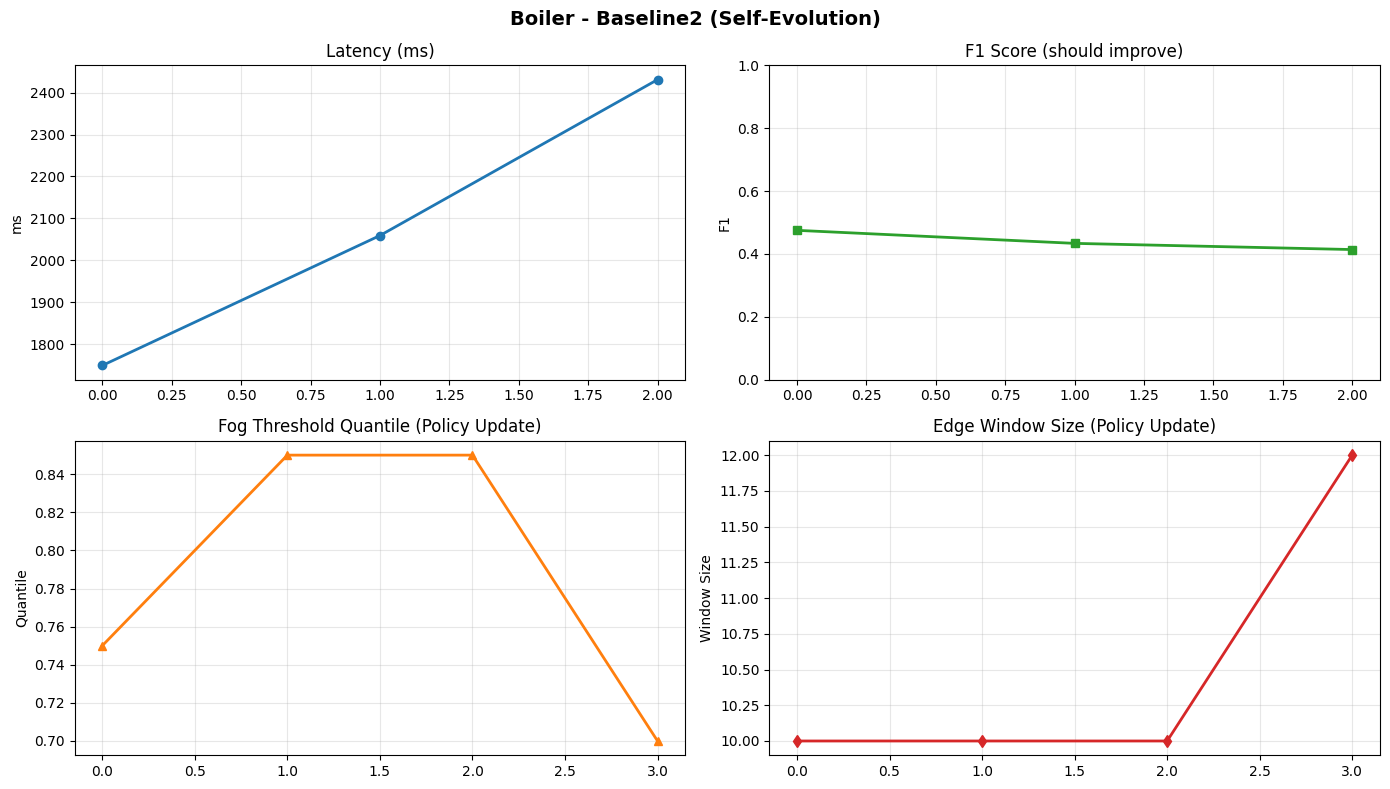

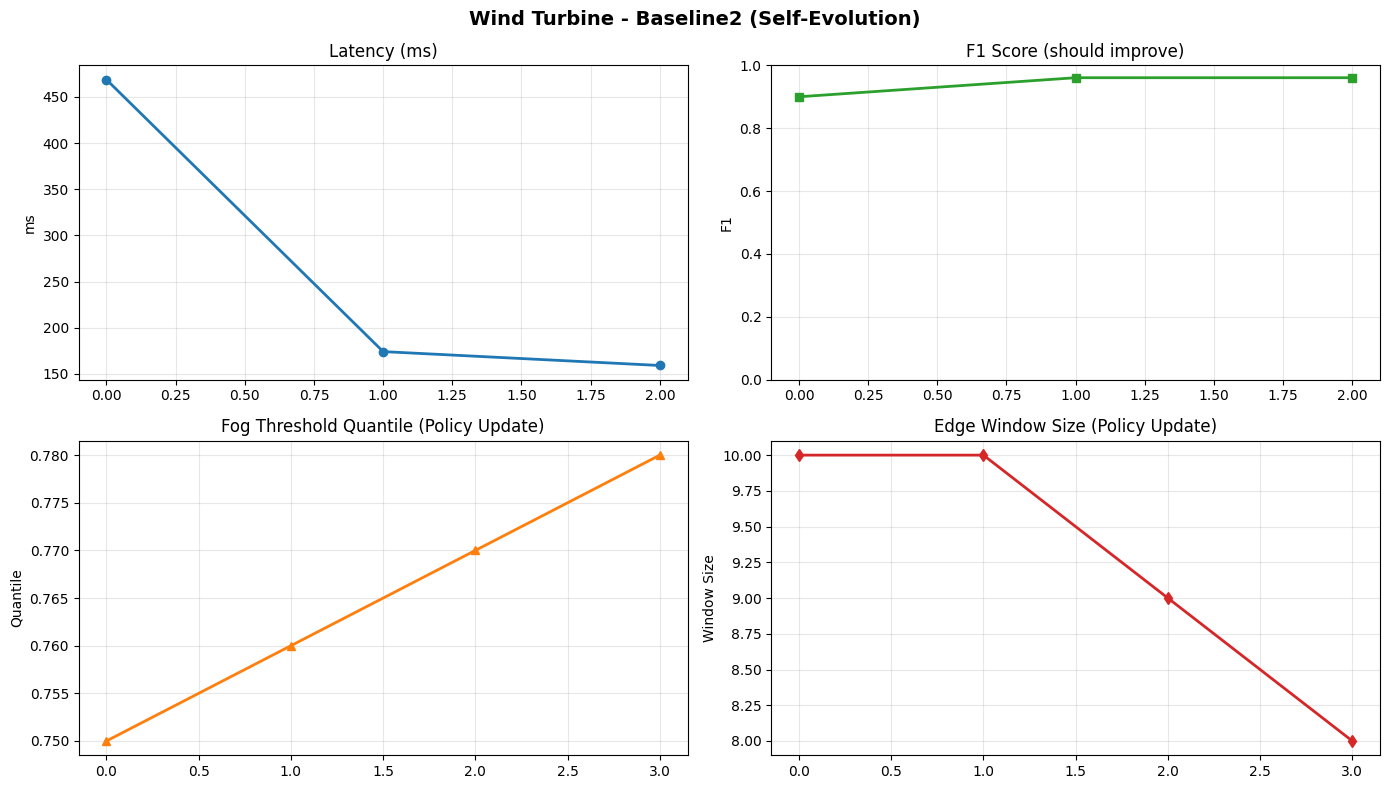

✅ Plots saved


In [ ]:
def plot_baseline2_bench(title: str, bench: Dict[str, list], policy_history: list):
    fig, ax = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle(f'{title} - Baseline2 (Self-Evolution)', fontsize=14, fontweight='bold')

    # Latency trend
    ax[0, 0].plot(bench['latency_ms'], marker='o', linewidth=2, color='#1f77b4')
    ax[0, 0].set_title('Latency (ms)')
    ax[0, 0].set_ylabel('ms')
    ax[0, 0].grid(True, alpha=0.3)

    # F1 trend (should improve with adaptation)
    ax[0, 1].plot(bench['f1'], marker='s', linewidth=2, color='#2ca02c')
    ax[0, 1].set_title('F1 Score (should improve)')
    ax[0, 1].set_ylabel('F1')
    ax[0, 1].set_ylim(0, 1)
    ax[0, 1].grid(True, alpha=0.3)

    # Policy: Threshold Quantile evolution
    thresholds = [p['fog']['threshold_quantile'] for p in policy_history]
    ax[1, 0].plot(thresholds, marker='^', linewidth=2, color='#ff7f0e')
    ax[1, 0].set_title('Fog Threshold Quantile (Policy Update)')
    ax[1, 0].set_ylabel('Quantile')
    ax[1, 0].grid(True, alpha=0.3)

    # Policy: Edge Window Size evolution
    windows = [p['edge']['window_size'] for p in policy_history]
    ax[1, 1].plot(windows, marker='d', linewidth=2, color='#d62728')
    ax[1, 1].set_title('Edge Window Size (Policy Update)')
    ax[1, 1].set_ylabel('Window Size')
    ax[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'baseline2_{title.lower()}_evolution.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_baseline2_bench('Boiler', b2_boiler.bench, b2_boiler.policy_history)
plot_baseline2_bench('Wind Turbine', b2_turbine.bench, b2_turbine.policy_history)

print('✅ Plots saved')


In [ ]:
# ============================================================================
# PERFORMANCE RESULTS COLLECTION FOR CROSS-PIPELINE COMPARISON
# ============================================================================
import pickle
from datetime import datetime

def collect_baseline2_performance(system, runs, dataset_name, system_name='Baseline2'):
    """
    Collect comprehensive performance metrics for Baseline2
    """
    performance_log = {
        'system': system_name,
        'dataset': dataset_name,
        'timestamp': datetime.now().isoformat(),
        'num_iterations': len(runs),
        'iterations': []
    }

    # Extract metrics from each episode
    for run in runs:
        iteration_metrics = {
            'iteration': run['episode'],
            'metrics': {},
            'latency_ms': run['latency_ms'],
            'layer_times': {},  # Baseline2 doesn't track layer times separately
            'policy_state': run['policy_state']
        }

        # Extract performance metrics from cloud report
        if 'cloud' in run and 'metrics' in run['cloud']:
            metrics = run['cloud']['metrics']
            iteration_metrics['metrics'] = {
                'accuracy': metrics.get('accuracy', 0),
                'precision': metrics.get('precision', 0),
                'recall': metrics.get('recall', 0),
                'f1': metrics.get('f1', 0),
                'roc_auc': metrics.get('roc_auc', 0),
                'mcc': metrics.get('mcc', 0),
                'fpr': metrics.get('false_positive_rate', 0),
                'fnr': metrics.get('false_negative_rate', 0),
                'cost_weighted_f1': metrics.get('cost_weighted_f1', 0)
            }

        performance_log['iterations'].append(iteration_metrics)

    # Calculate aggregated statistics
    if performance_log['iterations']:
        all_f1 = [it['metrics']['f1'] for it in performance_log['iterations']]
        all_precision = [it['metrics']['precision'] for it in performance_log['iterations']]
        all_recall = [it['metrics']['recall'] for it in performance_log['iterations']]
        all_latency = [it['latency_ms'] for it in performance_log['iterations']]

        performance_log['summary'] = {
            'avg_f1': np.mean(all_f1),
            'std_f1': np.std(all_f1) if len(all_f1) > 1 else 0,
            'avg_precision': np.mean(all_precision),
            'avg_recall': np.mean(all_recall),
            'avg_latency_ms': np.mean(all_latency),
            'f1_trajectory': all_f1,
            'f1_improvement': all_f1[-1] - all_f1[0] if len(all_f1) > 1 else 0
        }

        # Add policy evolution summary
        performance_log['policy_evolution'] = {
            'initial_threshold': system.policy_history[0]['fog']['threshold_quantile'],
            'final_threshold': system.policy_history[-1]['fog']['threshold_quantile'],
            'threshold_changes': len(system.policy_history) - 1,
            'policy_history': system.policy_history
        }

    return performance_log

# Collect performance results for both datasets
print('\n' + '='*80)
print('📦 COLLECTING BASELINE2 PERFORMANCE RESULTS')
print('='*80)

baseline2_performance_boiler = collect_baseline2_performance(
    b2_boiler,
    boiler_runs,
    'boiler',
    'Baseline2'
)

baseline2_performance_turbine = collect_baseline2_performance(
    b2_turbine,
    turbine_runs,
    'wind_turbine',
    'Baseline2'
)

print('\n✅ BOILER DATASET RESULTS:')
print(f'   Avg F1: {baseline2_performance_boiler["summary"]["avg_f1"]:.4f} ± {baseline2_performance_boiler["summary"]["std_f1"]:.4f}')
print(f'   Avg Precision: {baseline2_performance_boiler["summary"]["avg_precision"]:.4f}')
print(f'   Avg Recall: {baseline2_performance_boiler["summary"]["avg_recall"]:.4f}')
print(f'   Avg Latency: {baseline2_performance_boiler["summary"]["avg_latency_ms"]:.2f}ms')
print(f'   F1 Trajectory: {[f"{x:.4f}" for x in baseline2_performance_boiler["summary"]["f1_trajectory"]]}')
print(f'   F1 Improvement: {baseline2_performance_boiler["summary"]["f1_improvement"]:.4f}')
print(f'   Policy: Threshold {baseline2_performance_boiler["policy_evolution"]["initial_threshold"]:.3f} → {baseline2_performance_boiler["policy_evolution"]["final_threshold"]:.3f}')

print('\n✅ WIND TURBINE DATASET RESULTS:')
print(f'   Avg F1: {baseline2_performance_turbine["summary"]["avg_f1"]:.4f} ± {baseline2_performance_turbine["summary"]["std_f1"]:.4f}')
print(f'   Avg Precision: {baseline2_performance_turbine["summary"]["avg_precision"]:.4f}')
print(f'   Avg Recall: {baseline2_performance_turbine["summary"]["avg_recall"]:.4f}')
print(f'   Avg Latency: {baseline2_performance_turbine["summary"]["avg_latency_ms"]:.2f}ms')
print(f'   F1 Trajectory: {[f"{x:.4f}" for x in baseline2_performance_turbine["summary"]["f1_trajectory"]]}')
print(f'   F1 Improvement: {baseline2_performance_turbine["summary"]["f1_improvement"]:.4f}')
print(f'   Policy: Threshold {baseline2_performance_turbine["policy_evolution"]["initial_threshold"]:.3f} → {baseline2_performance_turbine["policy_evolution"]["final_threshold"]:.3f}')

# Save results to pickle files for cross-pipeline comparison
try:
    with open('baseline2_performance_boiler.pkl', 'wb') as f:
        pickle.dump(baseline2_performance_boiler, f)
    with open('baseline2_performance_turbine.pkl', 'wb') as f:
        pickle.dump(baseline2_performance_turbine, f)
    print('\n💾 Results saved to: baseline2_performance_boiler.pkl, baseline2_performance_turbine.pkl')
except Exception as e:
    print(f'\n⚠️  Could not save pickle files: {e}')

print('\n' + '='*80)
print('✅ BASELINE2 PERFORMANCE COLLECTION COMPLETE')
print('='*80)
print('\nNext Step:')
print('  Run Pipeline_Performance_Comparison.ipynb to compare all three systems!')


📦 COLLECTING BASELINE2 PERFORMANCE RESULTS

✅ BOILER DATASET RESULTS:
   Avg F1: 0.4411 ± 0.0255
   Avg Precision: 0.3072
   Avg Recall: 0.7847
   Avg Latency: 2079.71ms
   F1 Trajectory: ['0.4753', '0.4338', '0.4141']
   F1 Improvement: -0.0611
   Policy: Threshold 0.750 → 0.700

✅ WIND TURBINE DATASET RESULTS:
   Avg F1: 0.9404 ± 0.0286
   Avg Precision: 0.9212
   Avg Recall: 0.9617
   Avg Latency: 267.29ms
   F1 Trajectory: ['0.9000', '0.9606', '0.9606']
   F1 Improvement: 0.0606
   Policy: Threshold 0.750 → 0.780

💾 Results saved to: baseline2_performance_boiler.pkl, baseline2_performance_turbine.pkl

✅ BASELINE2 PERFORMANCE COLLECTION COMPLETE

Next Step:
  Run Pipeline_Performance_Comparison.ipynb to compare all three systems!
